# Setup



In [30]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import sys
import re

import torch
from torch import nn
import torch.optim as optim
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
from collections import Counter

import evaluate
metric=evaluate.load("sacrebleu")

from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorForLanguageModeling, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer


import logging
logging.getLogger("huggingface_hub").setLevel(logging.ERROR)
from huggingface_hub import login

models_path = r"../Models"
code_path = r"../Code"
data_path = r"../Dataset"

# Loading in the dataset



In [4]:
file = (os.path.join(code_path,r'HF_key.tex'))
with open(file) as f:
    lines = f.readlines()
    f.close()
    
HF_key = lines[0].split("= ")[1]

try:
    login(token=HF_key)
    print("Successfully logged in to Hugging Face Hub.")
except Exception as e:
    print(f"Failed to login to Hugging Face Hub: {e}")

Successfully logged in to Hugging Face Hub.


In [5]:
dataset = load_dataset("shpie/Hmong-to-Eng-4k")

train_hmong = dataset["train"]["Hmong"]
train_eng = dataset["train"]["English"]
test_hmong = dataset["test"]["Hmong"]
test_eng = dataset["test"]["Hmong"]

# Data Exploration



In [6]:
train = pd.DataFrame(dataset["train"])
test = pd.DataFrame(dataset["test"])

# Creating the full dataset
full = pd.concat([train, test])

In [79]:
print(len(train), len(test), len(full))

# Viewing special characters
print(train.iloc[743])

3872 969 4841
Hmong      Phau Ntawv Qhia By Your Side� hauv koj cheeb t...
English    A Parent Guide By Your Side� in your region wi...
Name: 743, dtype: object


In [104]:
lengths_hmong = []
lengths_english = []
for ii in range(len(full)):
    length_hm = len(full.iloc[ii]["Hmong"])
    length_en = len(full.iloc[ii]["English"])
    lengths_hmong.append(length_hm)
    lengths_english.append(length_en)
    
print("The longest Hmong sentence is: ", max(lengths_hmong), "character(s).",
     "\nThe shortest Hmong sentence is: ", min(lengths_hmong), "character(s).")

print("The longest English sentence is: ", max(lengths_english), "character(s).",
     "\nThe shortest English sentence is: ", min(lengths_english), "character(s).")

The longest Hmong sentence is:  1039 character(s). 
The shortest Hmong sentence is:  1 character(s).
The longest English sentence is:  811 character(s). 
The shortest English sentence is:  2 character(s).


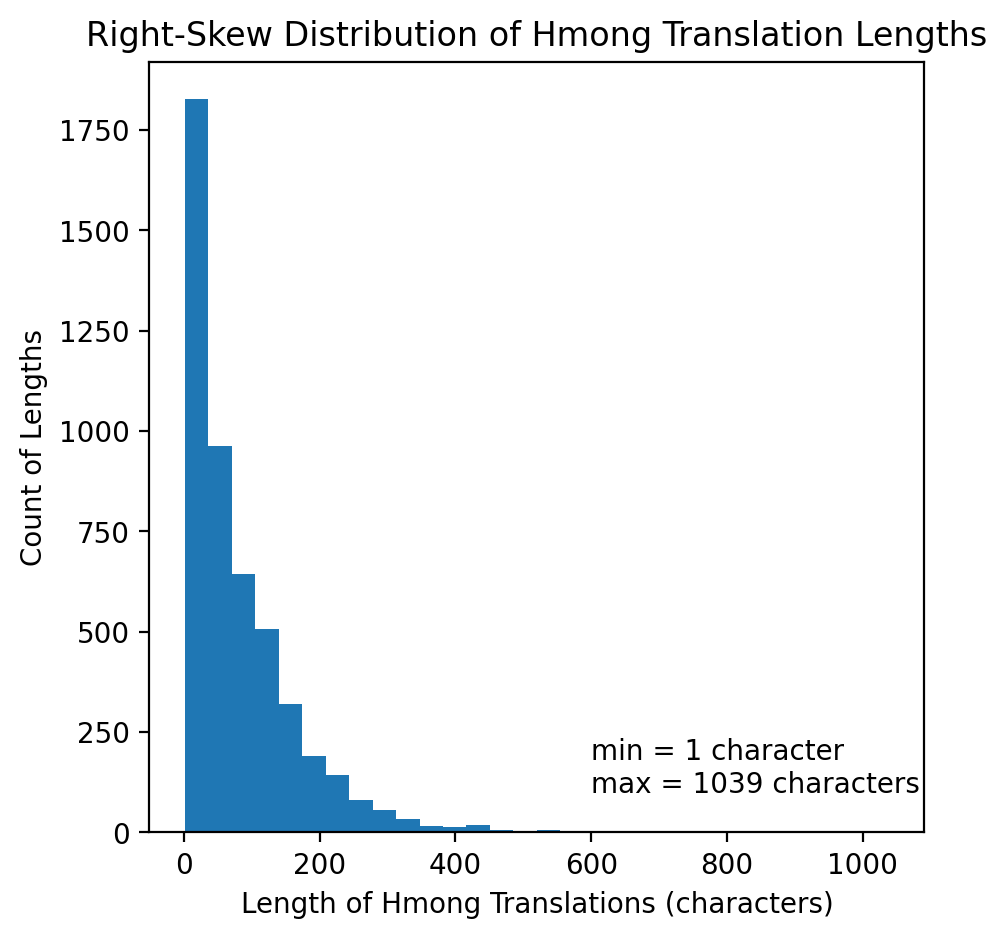

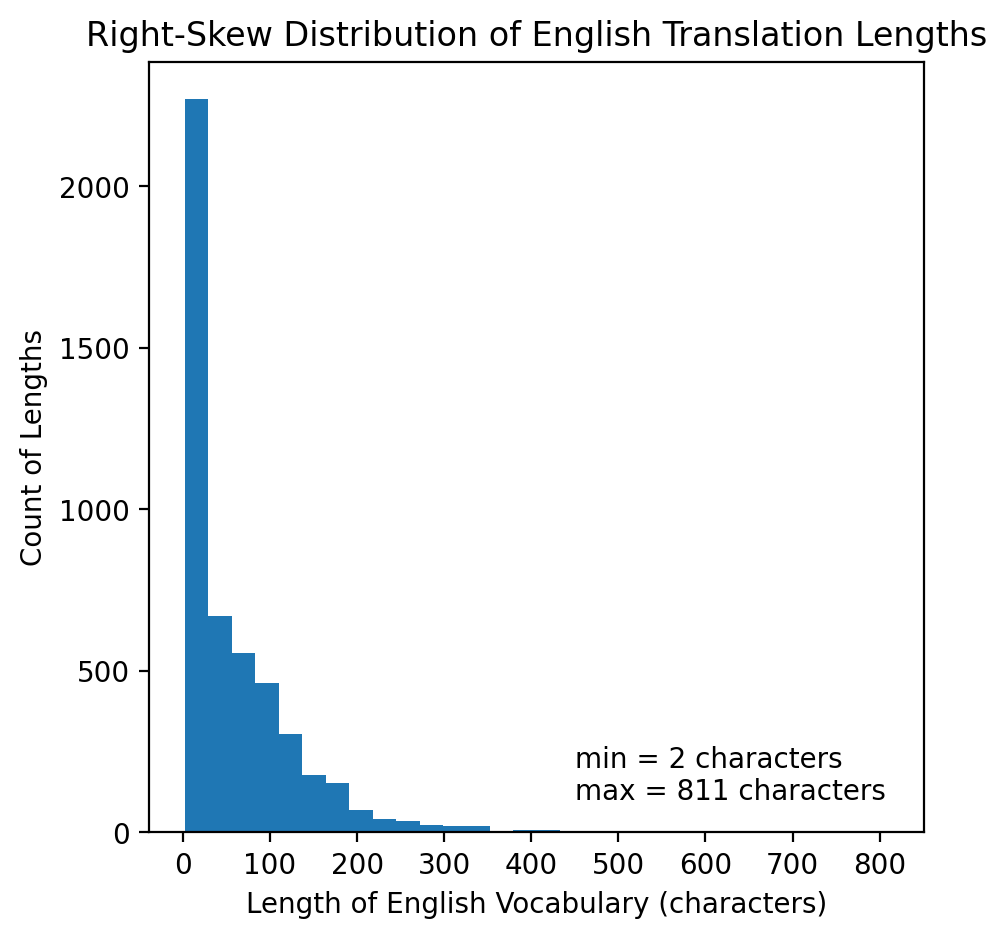

In [106]:
plt.figure(figsize=(5,5))
plt.hist(x = lengths_hmong, bins=30)
plt.xlabel("Length of Hmong Translations (characters)")
plt.ylabel("Count of Lengths")
plt.title("Right-Skew Distribution of Hmong Translation Lengths")
plt.annotate("min = 1 character\nmax = 1039 characters", xy = (600,100))
plt.show()

plt.figure(figsize=(5,5))
plt.hist(x = lengths_english, bins=30)
plt.xlabel("Length of English Vocabulary (characters)")
plt.ylabel("Count of Lengths")
plt.title("Right-Skew Distribution of English Translation Lengths")
plt.annotate("min = 2 characters\nmax = 811 characters", xy = (450,100))
plt.show()

In [64]:
hm_counts = Counter(full["Hmong"])

en_counts = Counter(full["English"])

print("Most common Hmong words: ",hm_counts.most_common(5), "\nMost common English words: ", en_counts.most_common(5))

Qog = full["English"][full["Hmong"]=="Qog"]
Rash = full["Hmong"][full["English"]=="Rash"]
Genitalia = full["Hmong"][full["English"]=="genitalia"]

print("The Hmong word 'Qog' can be translated into English as:\n", Qog,
     "\nThe English word 'Rash' can be translated into Hmong as:\n", Rash,
     "\nThe English word 'genetilia' can be translated into Hmong as:\n", Genitalia)

Most common Hmong words:  [('Qog', 7), ('Mob', 4), ('ua paug', 4), ('phob vog', 4), ('Siab', 3)] 
Most common English words:  [('Rash', 5), ('genitalia', 5), ('medication', 4), ('consent', 4), ('traditional (folk) healer', 4)]
The Hmong word 'Qog' can be translated into English as:
 1337        Lump
2262    Fibroids
3162     Tissues
3399      Nodule
3441    Thyroids
3531       Nodes
397        Cells
Name: English, dtype: object 
The English word 'Rash' can be translated into Hmong as:
 6       Nqaij ua pob xoo
711            pob khaus
1371                 Pob
3345         ua pob liab
264                 qoob
Name: Hmong, dtype: object 
The English word 'genetilia' can be translated into Hmong as:
 431         paum
1932         qau
2099         pim
2840    chaw mos
699         noov
Name: Hmong, dtype: object


# Creating a Tokenizer \- t5\-base trained on the Hmong corpus



In [130]:
#Getting the training corpus

all_data = []

for ii in range(0,len(full)):
    #Hmong
    hm = full.iloc[ii]["Hmong"]
    hm = hm.lower()
    hm = re.sub(r"[-.!?]+", r" ", hm)
    #English
    en = full.iloc[ii]["English"]
    en = en.lower()
    en = re.sub(r"[-.!?]+", r" ", en)
    all_data.append((hm.strip(), en.strip()))

def get_training_corpus():
    for i in range(0, len(all_data), 3000):
        for s, t in all_data:
            for sentence in (s, t):
                for word in sentence.split(" "):
                    yield word
        
training_corpus = get_training_corpus()

In [131]:
len(all_data)

4841

In [132]:
corpus = list(training_corpus)

In [140]:
corpus[150:160]

['in',
 'the',
 'resident�s',
 'health',
 'record',
 'nqaij',
 'ua',
 'pob',
 'xoo',
 'rash']

In [86]:
model_checkpoint = "trungnguyentran/t5-base-en2vi"

old_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

In [9]:
#Only run once
tokenizer = old_tokenizer.train_new_from_iterator(training_corpus, 52000)
#tokenizer.save_pretrained("Hmong_Tokenizer_t5_base")
tokenizer.push_to_hub("Hmong_Tokenizer_t5_base")

CommitInfo(commit_url='https://huggingface.co/shpie/Hmong_Tokenizer_t5_base/commit/73bb180485ed9fbc7df36745972984ad6944fa1a', commit_message='Upload tokenizer', commit_description='', oid='73bb180485ed9fbc7df36745972984ad6944fa1a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/shpie/Hmong_Tokenizer_t5_base', endpoint='https://huggingface.co', repo_type='model', repo_id='shpie/Hmong_Tokenizer_t5_base'), pr_revision=None, pr_num=None)

In [87]:
tokenizer = AutoTokenizer.from_pretrained("shpie/Hmong_Tokenizer_t5_base")

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

In [111]:
vocab = tokenizer.get_vocab()

list(vocab.items())[0:20]

[('▁priv', 4286),
 ('tiav', 6552),
 ('▁start', 1468),
 ('▁place', 1318),
 ('nes', 6427),
 ('▁education', 2111),
 ('tx', 5709),
 ('rifampin', 6175),
 ('▁txob', 3211),
 ('▁clinic/', 4039),
 ('tshooj', 4180),
 ('▁lymph', 2244),
 ('lk)', 2372),
 ('proper', 2399),
 ('race', 6658),
 ('▁bun', 3065),
 ('▁wor', 3058),
 ('▁lwm', 170),
 ('rhia', 3396),
 ('xias', 4641)]

# Building Model 1



## Tokenize for Hmong



In [11]:
prefix = "Translate Hmong to English"
max_target_length=128
max_input_length=128

def tokenize_Hmong(batch):
    return tokenizer(batch, padding=True, truncation=True, max_length=max_target_length)

In [12]:
tokenize_Hmong(train_hmong[0:2])

{'input_ids': [[342, 403, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [103, 2, 890, 185, 253, 171, 183, 110, 118, 106, 167, 113, 409, 112, 803, 231, 117, 189, 338, 155, 122, 103, 617, 475, 109, 138, 3230, 189, 277, 103, 144, 495, 138, 1240, 250, 154, 316, 130, 803, 231, 135, 123, 156, 161, 118, 389, 117, 189, 156, 146, 119, 113, 161, 122, 1128, 250, 154, 316, 130, 338, 173, 114, 170, 123, 103, 785, 146, 146, 114, 123, 156, 161, 118, 389, 117, 189, 156, 146, 119, 113, 161, 1]], 'attention_mask': [[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [13]:
#Testing tokenizer on inputs
h_sentence = dataset["train"]["Hmong"][1]
eng_sentence = dataset["train"]["English"][1]

inputs = tokenizer(h_sentence, text_target=eng_sentence)
inputs

{'input_ids': [103, 2, 890, 185, 253, 171, 183, 110, 118, 106, 167, 113, 409, 112, 803, 231, 117, 189, 338, 155, 122, 103, 617, 475, 109, 138, 3230, 189, 277, 103, 144, 495, 138, 1240, 250, 154, 316, 130, 803, 231, 135, 123, 156, 161, 118, 389, 117, 189, 156, 146, 119, 113, 161, 122, 1128, 250, 154, 316, 130, 338, 173, 114, 170, 123, 103, 785, 146, 146, 114, 123, 156, 161, 118, 389, 117, 189, 156, 146, 119, 113, 161, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [103, 2, 124, 5189, 104, 294, 184, 4113, 105, 140, 924, 105, 125, 108, 1218, 2826, 634, 143, 618, 128, 1918, 3098, 4406, 148, 1478, 527, 1240, 515, 556, 634, 238, 109, 108, 579, 142, 143, 2514, 111, 1676, 224, 464, 128, 103, 104, 2215, 515, 556, 618, 126, 836, 851, 164, 287, 108, 579, 142, 143, 251

In [14]:
output = tokenizer.decode(inputs['input_ids'])
output

'<unk>uav tsum sau ntawv qhia cov neeg mob txog kev npaj rho tawm los sis hloov chaw thiab seb vim li cast sis pub dhau li 30 hnub ua ntej yuav rho tawm ntawm lub tsev tu neeg laus los sis tsev nyob muaj kev tu thiab xya hnub ua ntej yuav hloov mus rau lwm lub chav nyob nyob rau lub tsev tu neeg laus los sis tsev nyob muaj kev tu</s>'

In [15]:
source_lang = "Hmong"
target_lang = "English"

def preprocess_function(examples):
    inputs = [prefix + ex for ex in examples[source_lang]]
    targets = [ex for ex in examples[target_lang]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [16]:
#Testing preprocess_function
processed = preprocess_function(dataset["train"][2])
processed

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4109: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'input_ids': [[103, 2, 165, 762, 104, 2696, 103, 2, 109, 4453, 126, 103, 2, 1379, 2698, 2, 1], [103, 2, 165, 762, 104, 2696, 103, 2, 109, 4453, 126, 103, 2, 1379, 2698, 133, 1], [103, 2, 165, 762, 104, 2696, 103, 2, 109, 4453, 126, 103, 2, 1379, 2698, 107, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[103, 2, 1], [421, 1], [103, 282, 1], [103, 124, 1], [429, 1], [202, 1], [344, 1], [103, 133, 1], [421, 1]]}

In [17]:
tokenized_datasets = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=['Hmong', 'English'],
)

Map:   0%|          | 0/3872 [00:00<?, ? examples/s]

Map:   0%|          | 0/969 [00:00<?, ? examples/s]

## Train Model 1



In [18]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]
    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    # Decode token IDs to text
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 (used to mask loss calculation) with padding token ID for decoding
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Clean up spacing and format references properly
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    # Compute BLEU score
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    # Track average length of generated sequences
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)

    # Round values for readability
    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [19]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [20]:
batch_size = 16
model_name = model_checkpoint.split("/")[-1]

args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-{source_lang}-to-{target_lang}",
    eval_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    remove_unused_columns=True,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=True
)

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [21]:
m1_results = trainer.train()

/usr/local/lib/python3.10/dist-packages/apex/_autocast_utils.py:26: FutureWarning: `torch.cuda.amp.autocast_mode._cast(value, dtype)` is deprecated. Please use `torch.amp.autocast_mode._cast(value, 'cuda', dtype)` instead.
  return torch.cuda.amp.autocast_mode._cast(args, torch.get_autocast_gpu_dtype())


Epoch,Training Loss,Validation Loss


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/apex/_autocast_utils.py:26: FutureWarning: `torch.cuda.amp.autocast_mode._cast(value, dtype)` is deprecated. Please use `torch.amp.autocast_mode._cast(value, 'cuda', dtype)` instead.
  return torch.cuda.amp.autocast_mode._cast(args, torch.get_autocast_gpu_dtype())


In [22]:
trainer.evaluate()

{'eval_loss': 5.949235439300537,
 'eval_bleu': 0.0585,
 'eval_gen_len': 9.2157,
 'eval_runtime': 75.9576,
 'eval_samples_per_second': 12.757,
 'eval_steps_per_second': 0.803,
 'epoch': 1.0}

# Building Model 2



## Tokenize for English



In [23]:
source_lang = "English"
target_lang = "Hmong"
prefix = "Translate from English to Hmong"

def preprocess_function_eng(examples):
    inputs = [prefix + ex for ex in examples[source_lang]]
    targets = [ex for ex in examples[target_lang]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets_eng = dataset.map(
    preprocess_function_eng,
    batched=True,
    remove_columns=['Hmong', 'English'],
)

Map:   0%|          | 0/3872 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4109: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/969 [00:00<?, ? examples/s]

In [24]:
#Testing tokenizer on inputs
h_sentence = dataset["train"]["Hmong"][1]
eng_sentence = dataset["train"]["English"][1]

inputs = tokenizer(eng_sentence, text_target=h_sentence)
inputs

{'input_ids': [103, 2, 124, 5189, 104, 294, 184, 4113, 105, 140, 924, 105, 125, 108, 1218, 2826, 634, 143, 618, 128, 1918, 3098, 4406, 148, 1478, 527, 1240, 515, 556, 634, 238, 109, 108, 579, 142, 143, 2514, 111, 1676, 224, 464, 128, 103, 104, 2215, 515, 556, 618, 126, 836, 851, 164, 287, 108, 579, 142, 143, 2514, 111, 1676, 224, 464, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [103, 2, 890, 185, 253, 171, 183, 110, 118, 106, 167, 113, 409, 112, 803, 231, 117, 189, 338, 155, 122, 103, 617, 475, 109, 138, 3230, 189, 277, 103, 144, 495, 138, 1240, 250, 154, 316, 130, 803, 231, 135, 123, 156, 161, 118, 389, 117, 189, 156, 146, 119, 113, 161, 122, 1128, 250, 154, 316, 130, 338, 173, 114, 170, 123, 103, 785, 146, 146, 114, 123, 156, 161, 118, 389, 117, 189, 156, 146, 119, 113, 161, 1]}

In [25]:
output = tokenizer.decode(inputs['input_ids'])
output

'<unk>esidents must be notified, in writing, of the proposed discharge or transfer and its justification no later than 30 days before discharge from the nursing or boarding care home and seven days before transfer to another room within the nursing or boarding care home</s>'

## Test Model 2



In [26]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]
    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    # Decode token IDs to text
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 (used to mask loss calculation) with padding token ID for decoding
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Clean up spacing and format references properly
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    # Compute BLEU score
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    # Track average length of generated sequences
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)

    # Round values for readability
    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [27]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [28]:
batch_size = 16
model_name = model_checkpoint.split("/")[-1]

args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-{source_lang}-to-{target_lang}",
    eval_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    remove_unused_columns=True,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=True
)

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets_eng["train"],
    eval_dataset=tokenized_datasets_eng["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [29]:
m2_results = trainer.train()

/usr/local/lib/python3.10/dist-packages/apex/_autocast_utils.py:26: FutureWarning: `torch.cuda.amp.autocast_mode._cast(value, dtype)` is deprecated. Please use `torch.amp.autocast_mode._cast(value, 'cuda', dtype)` instead.
  return torch.cuda.amp.autocast_mode._cast(args, torch.get_autocast_gpu_dtype())


Epoch,Training Loss,Validation Loss


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/apex/_autocast_utils.py:26: FutureWarning: `torch.cuda.amp.autocast_mode._cast(value, dtype)` is deprecated. Please use `torch.amp.autocast_mode._cast(value, 'cuda', dtype)` instead.
  return torch.cuda.amp.autocast_mode._cast(args, torch.get_autocast_gpu_dtype())


In [30]:
trainer.evaluate()

{'eval_loss': 5.352731227874756,
 'eval_bleu': 0.0035,
 'eval_gen_len': 11.4737,
 'eval_runtime': 76.0653,
 'eval_samples_per_second': 12.739,
 'eval_steps_per_second': 0.802,
 'epoch': 1.0}